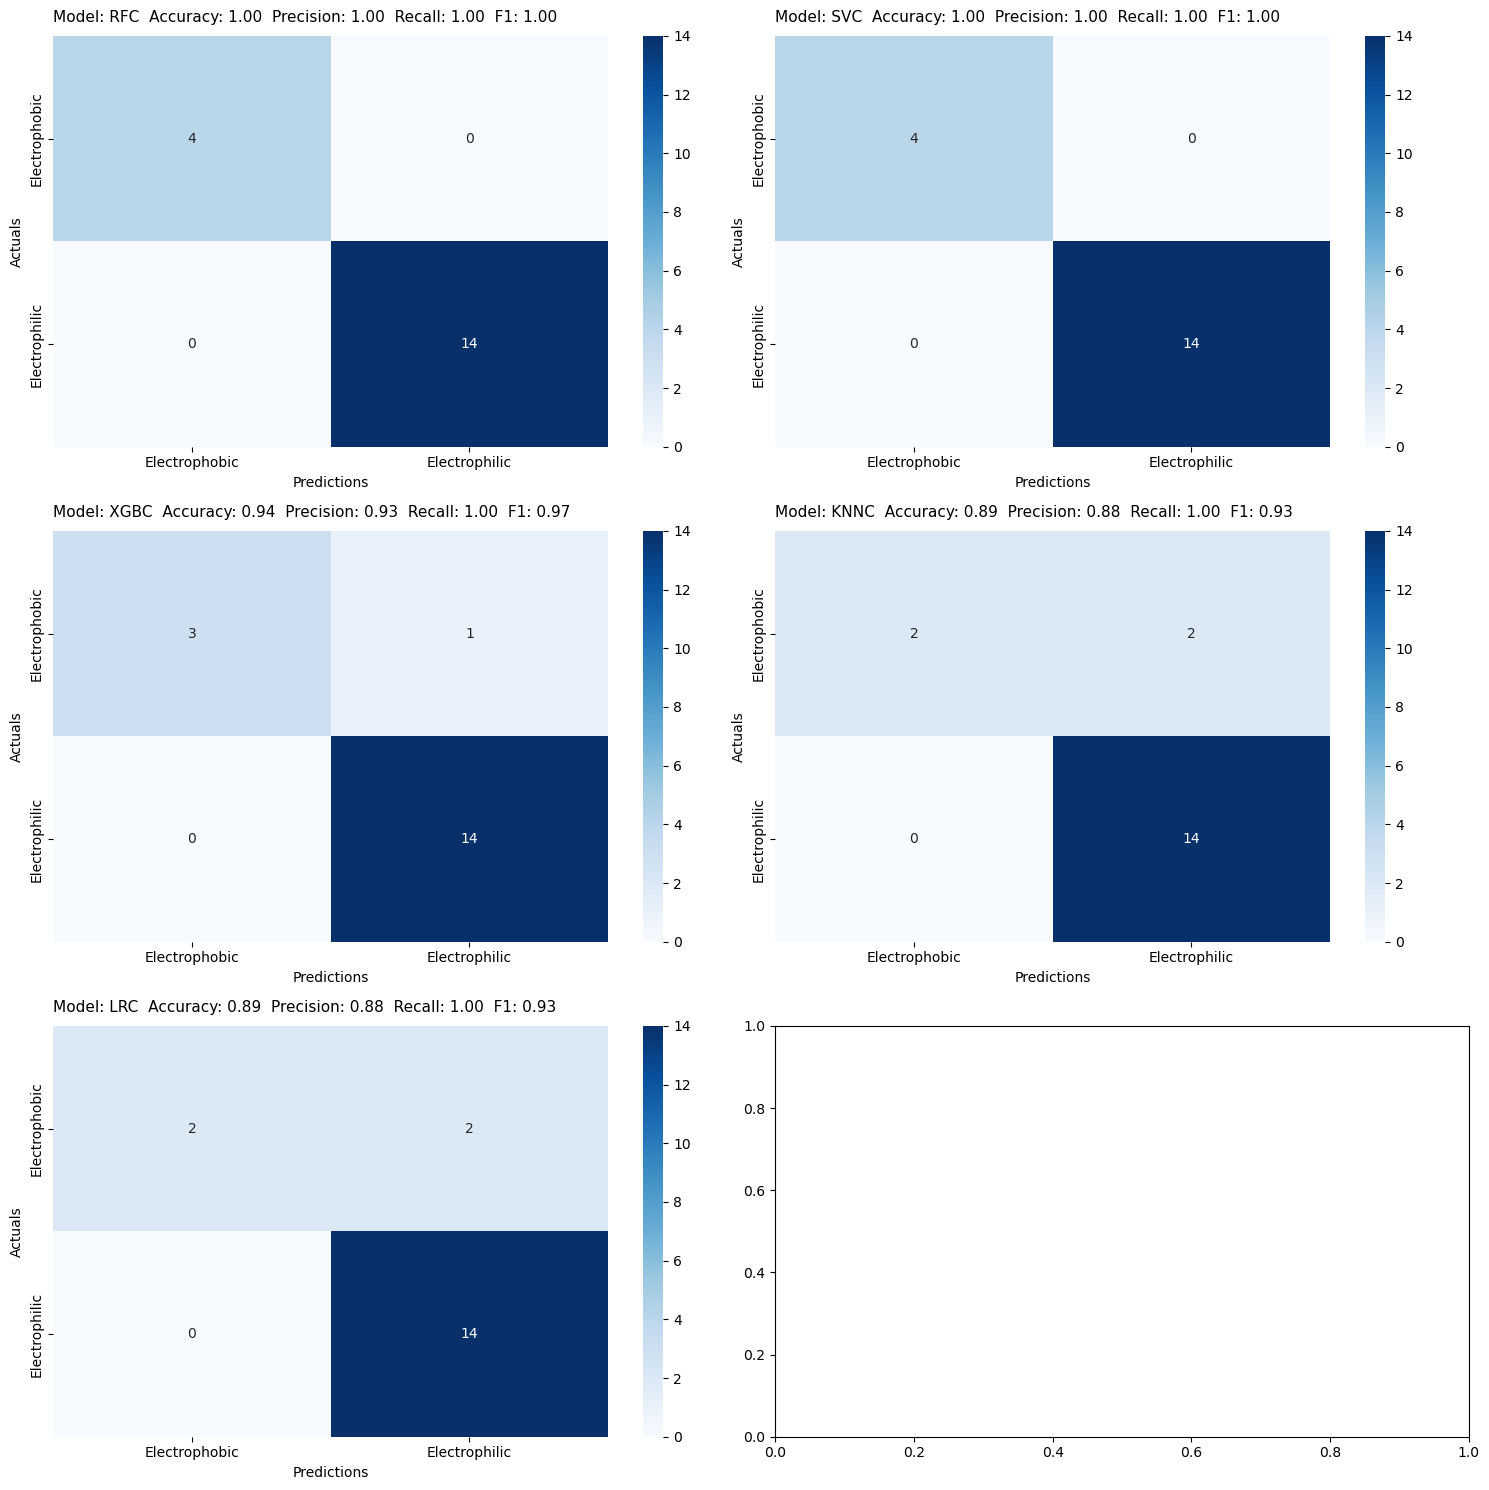

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# Load data
data = pd.read_excel('EPOC dataset.xlsx')
validate_data = pd.read_excel('Validate dataset.xlsx')


# Data preprocessing
columns = ['metal', 'support', 'wt.%', 'solid electrolyte', 'ionic species', 'ionic species charge', 
           'particle size(nm)', 'metal loading (mg)', 'catalyst redox', 'CO2:H2 ratio', 'temp(℃)', 
           'rCO(mol/s)', 'voltage(V)', 'current(mA)', 'ρCO', 'ΛCO']

# Validation data preprocessing
validate_data.columns = columns
validate_data['metal'] = validate_data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                                        [55.8, 58.9, 58.7, 63.5, 65.4, 101.1, 102.9, 106.4, 195.1])
validate_data['wt.%'] = validate_data['wt.%'].fillna(100).astype(float)
validate_data['gas ratio'] = validate_data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))
validate_data = validate_data.drop('CO2:H2 ratio', axis=1)
validate_data.columns = ['M', 'S', 'WT', 'SE', 'IS', 'ISC', 'PS', 'L', 'CR', 'T', 'RR', 'V', 'C', 'ρ', 'Λ', 'GR']

# determine the ionic species charge
ionic_charge = {
    'O2-': -2,
    'H+': 1,
    'Li+': 1,
    'Na+': 1,
    'K+': 1,
    'none': 0
}
validate_data['IS_charge'] = validate_data['IS'].replace(ionic_charge).fillna(0).astype(float)

# define a function to determine which direction the IS migrates. Value of 1 means IS moves to catalyst, -1 means IS removes from catalyst
def ionic_dir(row):
    if row['IS_charge'] * row['V'] < 0:
        return 1
    else:
        return -1
# create a new column named 'MD' (migration direction)
validate_data['MD'] = validate_data.apply(ionic_dir, axis=1)

def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

validate_data['BH'] = validate_data.apply(electro_class, axis=1)

# Feature and target selection
features = ['M', 'L', 'T', 'V', 'GR']
X_v = validate_data[features]
y_v = validate_data['BH']

# Feature scaling
scaler = StandardScaler()
X_v_scaled = scaler.fit_transform(X_v)

# Train and evaluate models
models = {
    'RFC': RandomForestClassifier(n_estimators=15, max_depth=6, min_samples_split=2, random_state=0),
    'SVC': SVC(kernel='rbf', C=10, gamma=0.1, probability=False, random_state=0),
    'XGBC': xgb.XGBClassifier(n_estimators=10, eta=0.3, max_depth=6, colsample_bytree=1, subsample=1, random_state=0),
    'KNNC': KNeighborsClassifier(n_neighbors=5, metric='manhattan'),
    'LRC': LogisticRegression(C=1)
}

predictions = {}
for name, model in models.items():
    model.fit(X_v_scaled, y_v)
    predictions[name] = model.predict(X_v_scaled)

# Plotting
fig, subaxes = plt.subplots(3, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
subaxes = subaxes.flatten()

for i, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_v, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=subaxes[i],
                xticklabels=['Electrophobic','Electrophilic'], yticklabels=['Electrophobic','Electrophilic'])

    acc = accuracy_score(y_v, y_pred)
    pre = precision_score(y_v, y_pred)
    rec = recall_score(y_v, y_pred)
    f1 = f1_score(y_v, y_pred)
    
    subaxes[i].set_title(f'Model: {name}  Accuracy: {acc:.2f}  Precision: {pre:.2f}  Recall: {rec:.2f}  F1: {f1:.2f}', pad=10, fontsize=11, ha='left', loc='left')
    subaxes[i].set_xlabel(f'Accuracy: {acc:.2f}  Precision: {pre:.2f}  Recall: {rec:.2f}  F1: {f1:.2f}')
    subaxes[i].set_ylabel('Actuals')
    subaxes[i].set_xlabel('Predictions')

plt.tight_layout()
plt.show()